In [2]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import nltk
import math
import time
import re
import os
import seaborn as sns
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import time
from plotly.graph_objs import Scatter, Layout
plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('winemagdata-130k')
data.head()


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
data.shape

(129971, 14)

In [5]:
data = data.loc[:,['description','designation','country','title','variety','price','province','winery']]
data.shape

(129971, 8)

In [6]:
data['description'].describe()

count                                                129971
unique                                               119955
top       Ripe plum, game, truffle, leather and menthol ...
freq                                                      3
Name: description, dtype: object

In [7]:
data['variety'].describe()

count         129970
unique           707
top       Pinot Noir
freq           13272
Name: variety, dtype: object

In [8]:
data = data.loc[~data['variety'].isnull()]
data.shape[0]

129970

In [9]:
data['country'].describe()

count     129907
unique        43
top           US
freq       54504
Name: country, dtype: object

In [10]:
data = data.loc[~data['country'].isnull()]
print('Number of data points After eliminating country=NULL :', data.shape[0])

Number of data points After eliminating country=NULL : 129907


In [11]:
data['designation'].describe()

count       92454
unique      37954
top       Reserve
freq         2006
Name: designation, dtype: object

In [12]:
data =data.loc[~data['designation'].isnull()]
print('Number of data points After eliminating designation = NULL :', data.shape[0])

Number of data points After eliminating designation = NULL : 92454


In [13]:
data['winery'].describe()

count                  92454
unique                 12538
top       Wines & Winemakers
freq                     222
Name: winery, dtype: object

In [14]:
data = data.loc[~data['price'].isnull()]
data.shape

(86148, 8)

In [15]:
data.head()

,description,designation,country,title,variety,price,province,winery
1,"This is ripe and fruity, a wine that is smooth...",Avidagos,Portugal,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,15.0,Douro,Quinta dos Avidagos
3,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,US,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,13.0,Michigan,St. Julian
4,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,US,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,65.0,Oregon,Sweet Cheeks
5,Blackberry and raspberry aromas show a typical...,Ars In Vitro,Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,15.0,Northern Spain,Tandem
6,"Here's a bright, informal red that opens with ...",Belsito,Italy,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,16.0,Sicily & Sardinia,Terre di Giurfo


In [16]:
dup = data.duplicated('description')
dup = pd.DataFrame(dup)
print(type(dup))
dup.head()
dup.columns = ['bool']    
dup.head()

<class 'pandas.core.frame.DataFrame'>


,bool
1,False
3,False
4,False
5,False
6,False


In [17]:
index = dup.loc[dup['bool'] == True]
index

,bool
2409,True
2410,True
2412,True
2413,True
2694,True
3431,True
3432,True
3433,True
4093,True
4094,True


In [18]:
for i in index.iterrows():
    data = data.drop(i[0])

In [19]:
data.shape

(79477, 8)

In [20]:
dup_title = data.duplicated('title')
dup_title = pd.DataFrame(dup_title)
dup_title.columns = ['bool']    
dup_title.head()
indx = dup_title.loc[dup_title['bool'] == True]
for i in indx.iterrows():
    data = data.drop(i[0])
    

In [21]:
data.to_pickle('pickels/data_dedupe')

In [39]:
data = pd.read_pickle('pickels/data_dedupe')

In [40]:
data.shape

(78708, 8)

In [41]:
g=data.groupby('variety')
data = g.filter(lambda x: len(x) > 100)
data['variety'].describe()

count          72276
unique            68
top       Pinot Noir
freq            8779
Name: variety, dtype: object

In [42]:
Counter(data['variety'])

Counter({'Aglianico': 200,
         'Albariño': 199,
         'Barbera': 357,
         'Blaufränkisch': 127,
         'Bordeaux-style Red Blend': 2692,
         'Bordeaux-style White Blend': 226,
         'Cabernet Franc': 725,
         'Cabernet Sauvignon': 5350,
         'Carmenère': 458,
         'Champagne Blend': 953,
         'Chardonnay': 6757,
         'Chenin Blanc': 345,
         'Corvina, Rondinella, Molinara': 296,
         'G-S-M': 138,
         'Gamay': 537,
         'Garganega': 160,
         'Garnacha': 234,
         'Gewürztraminer': 612,
         'Glera': 494,
         'Grenache': 439,
         'Grüner Veltliner': 896,
         'Malbec': 1813,
         'Melon': 213,
         'Mencía': 110,
         'Meritage': 125,
         'Merlot': 1491,
         'Montepulciano': 136,
         'Moscato': 169,
         'Mourvèdre': 135,
         'Nebbiolo': 1708,
         "Nero d'Avola": 216,
         'Petit Verdot': 159,
         'Petite Sirah': 390,
         'Pinot Blanc': 190,
   

In [43]:
target = pd.DataFrame(data['variety'])
target.columns = ['variety']
data = data.drop('variety',axis=1)
print(target.head())
print(data.columns)

          variety
1  Portuguese Red
3        Riesling
4      Pinot Noir
8  Gewürztraminer
9      Pinot Gris
Index(['description', 'designation', 'country', 'title', 'price', 'province',
       'winery'],
      dtype='object')


In [29]:
'''red_wines = {'cabernet_sauvignon','shiraz','merlot','pinot_noir','grenache','red_blend','chianti','barolo','amarone',
             'barbera','zinfandel','lambrusco','montepulciano','valpolicella','barbaresco','bardolino','beaujolais','schicava'
            'gamay','garnacha','garnache','carmenere','cabernet_franc','valpolicella_blend','mencia','sangiovese','negroamaro'
            'g_s_m','rhone_style_red_blend','montepulciano'}
white_wines = {'albarino','aligote','auslese','sauvignon','verdelho','semillon','chardonnay','riesling','pinot_gris',
               'pinot_grigio','white_blend','blanc_e_blancs'}
sparkling_wines = {'champagne','sparkling_white','sparkling_red','sparkling_rose','sparkling_blend','asti_spumante'}

def converting(total_text, index, column):
    string = ""
    # replace evershoy special char with space
    total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
    # replace multiple spaces with single space
    total_text = re.sub('\s','_', total_text)
    # converting all the chars into lower-case.
    total_text = total_text.lower()
    for words in total_text.split():

        if words in red_wines:
            words = 'red_wines'
            string += words
        elif words in white_wines:
            words = 'white_wines'
            string += words
        elif words in sparkling_wines:
            words = 'sparkling_wines'
            string += words
        else:
            string += words
    target[column][index] = string
for index, row in target.iterrows():
    converting(row['variety'], index, 'variety')   '''     

In [44]:
target.shape

(72276, 1)

In [32]:
target.to_pickle('pickels/target')

In [33]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'not', 'an', 'other', 'mightn', 'didn', 'myself', 'was', 'are', 'very', 'be', 'during', 'over', 'only', 'we', 'both', 'have', 'which', 'his', 'its', 'them', 'against', 'ma', 'after', 'more', 'most', 'won', 'your', 'do', 'you', 'o', 'isn', 'so', 'has', 'shan', 'own', 'couldn', 'their', 'my', 'yours', 'nor', 'is', 'when', 'by', 'each', 'm', 'am', 'don', 'd', 'in', 'further', 'all', 'these', 'does', 'ain', 'weren', 're', 'haven', 'hers', 'he', 'did', 'ours', 'hasn', 'himself', 'she', 'having', 'for', 'once', 'they', 'can', 'wasn', 'theirs', 'ourselves', 'under', 'hadn', 'too', 'any', 'no', 'before', 'shouldn', 'through', 't', 'yourself', 'those', 'had', 'needn', 'because', 'at', 'been', 'to', 'just', 'our', 'who', 'him', 'yourselves', 'should', 'same', 'then', 'and', 've', 'that', 'y', 'were', 'where', 'doesn', 'while', 'as', 'down', 'out', 'how', 'above', 'again', 'until', 'there', 'why', 'herself', 'it', 'here', 'some', 'will', 'i', 'itself', 'of', 'her', 'from', 'b

In [34]:
import time
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['description'], index, 'description')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

10879.265836138378 seconds


In [35]:
data.to_pickle('pickels/after_stopwrds')

In [36]:
data = pd.read_pickle('pickels/after_stopwrds')

In [75]:
target['variety'] = target['variety'].astype('category')
cat_columns = target.select_dtypes(['category']).columns
target[cat_columns] = target[cat_columns].apply(lambda x: x.cat.codes)
Counter(target['variety'])

Counter({0: 200,
         1: 199,
         2: 357,
         3: 127,
         4: 2692,
         5: 226,
         6: 725,
         7: 5350,
         8: 458,
         9: 953,
         10: 6757,
         11: 345,
         12: 296,
         13: 138,
         14: 537,
         15: 160,
         16: 234,
         17: 612,
         18: 494,
         19: 439,
         20: 896,
         21: 1813,
         22: 213,
         23: 110,
         24: 125,
         25: 1491,
         26: 136,
         27: 169,
         28: 135,
         29: 1708,
         30: 216,
         31: 159,
         32: 390,
         33: 190,
         34: 339,
         35: 703,
         36: 102,
         37: 8779,
         38: 454,
         39: 1892,
         40: 841,
         41: 133,
         42: 162,
         43: 6503,
         44: 1071,
         45: 330,
         46: 3857,
         47: 2086,
         48: 1248,
         49: 229,
         50: 147,
         51: 2496,
         52: 531,
         53: 1565,
         54: 2785,
    

In [76]:
from sklearn.model_selection import train_test_split
X_train, test_df, y_train, y_test = train_test_split(data,target, stratify=target, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [85]:
print(train_df.shape)
print(cv_df.shape)
print(test_df.shape)

(46256, 7)
(11564, 7)
(14456, 7)


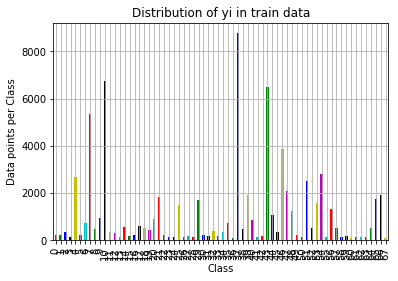

Number of data points in class 38 : 8779 ( 18.979 %)
Number of data points in class 11 : 6757 ( 14.608 %)
Number of data points in class 44 : 6503 ( 14.059 %)
Number of data points in class 8 : 5350 ( 11.566 %)
Number of data points in class 47 : 3857 ( 8.338 %)
Number of data points in class 55 : 2785 ( 6.021 %)
Number of data points in class 5 : 2692 ( 5.82 %)
Number of data points in class 52 : 2496 ( 5.396 %)
Number of data points in class 48 : 2086 ( 4.51 %)
Number of data points in class 67 : 1901 ( 4.11 %)
Number of data points in class 40 : 1892 ( 4.09 %)
Number of data points in class 22 : 1813 ( 3.919 %)
Number of data points in class 66 : 1742 ( 3.766 %)
Number of data points in class 30 : 1708 ( 3.692 %)
Number of data points in class 54 : 1565 ( 3.383 %)
Number of data points in class 26 : 1491 ( 3.223 %)
Number of data points in class 57 : 1312 ( 2.836 %)
Number of data points in class 49 : 1248 ( 2.698 %)
Number of data points in class 45 : 1071 ( 2.315 %)
Number of data

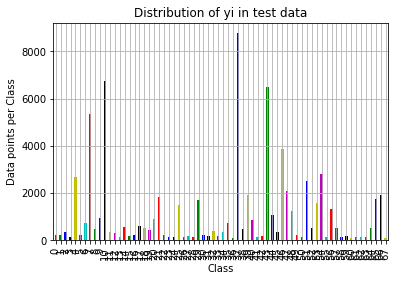

Number of data points in class 38 : 8779 ( 60.729 %)
Number of data points in class 11 : 6757 ( 46.742 %)
Number of data points in class 44 : 6503 ( 44.985 %)
Number of data points in class 8 : 5350 ( 37.009 %)
Number of data points in class 47 : 3857 ( 26.681 %)
Number of data points in class 55 : 2785 ( 19.265 %)
Number of data points in class 5 : 2692 ( 18.622 %)
Number of data points in class 52 : 2496 ( 17.266 %)
Number of data points in class 48 : 2086 ( 14.43 %)
Number of data points in class 67 : 1901 ( 13.15 %)
Number of data points in class 40 : 1892 ( 13.088 %)
Number of data points in class 22 : 1813 ( 12.542 %)
Number of data points in class 66 : 1742 ( 12.05 %)
Number of data points in class 30 : 1708 ( 11.815 %)
Number of data points in class 54 : 1565 ( 10.826 %)
Number of data points in class 26 : 1491 ( 10.314 %)
Number of data points in class 57 : 1312 ( 9.076 %)
Number of data points in class 49 : 1248 ( 8.633 %)
Number of data points in class 45 : 1071 ( 7.409 %)
N

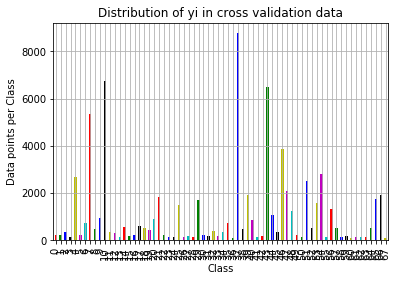

Number of data points in class 38 : 8779 ( 75.917 %)
Number of data points in class 11 : 6757 ( 58.431 %)
Number of data points in class 44 : 6503 ( 56.235 %)
Number of data points in class 8 : 5350 ( 46.264 %)
Number of data points in class 47 : 3857 ( 33.354 %)
Number of data points in class 55 : 2785 ( 24.083 %)
Number of data points in class 5 : 2692 ( 23.279 %)
Number of data points in class 52 : 2496 ( 21.584 %)
Number of data points in class 48 : 2086 ( 18.039 %)
Number of data points in class 67 : 1901 ( 16.439 %)
Number of data points in class 40 : 1892 ( 16.361 %)
Number of data points in class 22 : 1813 ( 15.678 %)
Number of data points in class 66 : 1742 ( 15.064 %)
Number of data points in class 30 : 1708 ( 14.77 %)
Number of data points in class 54 : 1565 ( 13.533 %)
Number of data points in class 26 : 1491 ( 12.893 %)
Number of data points in class 57 : 1312 ( 11.346 %)
Number of data points in class 49 : 1248 ( 10.792 %)
Number of data points in class 45 : 1071 ( 9.262 

In [90]:
train_class_distribution = target['variety'].value_counts().sortlevel()
test_class_distribution = target['variety'].value_counts().sortlevel()
cv_class_distribution = target['variety'].value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*200)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*200)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


In [101]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
             ,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(100,80))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(100,80))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(100,80))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 4.52746026519
Log loss on Test Data using Random Model 4.54156130961
-------------------- Confusion matrix --------------------


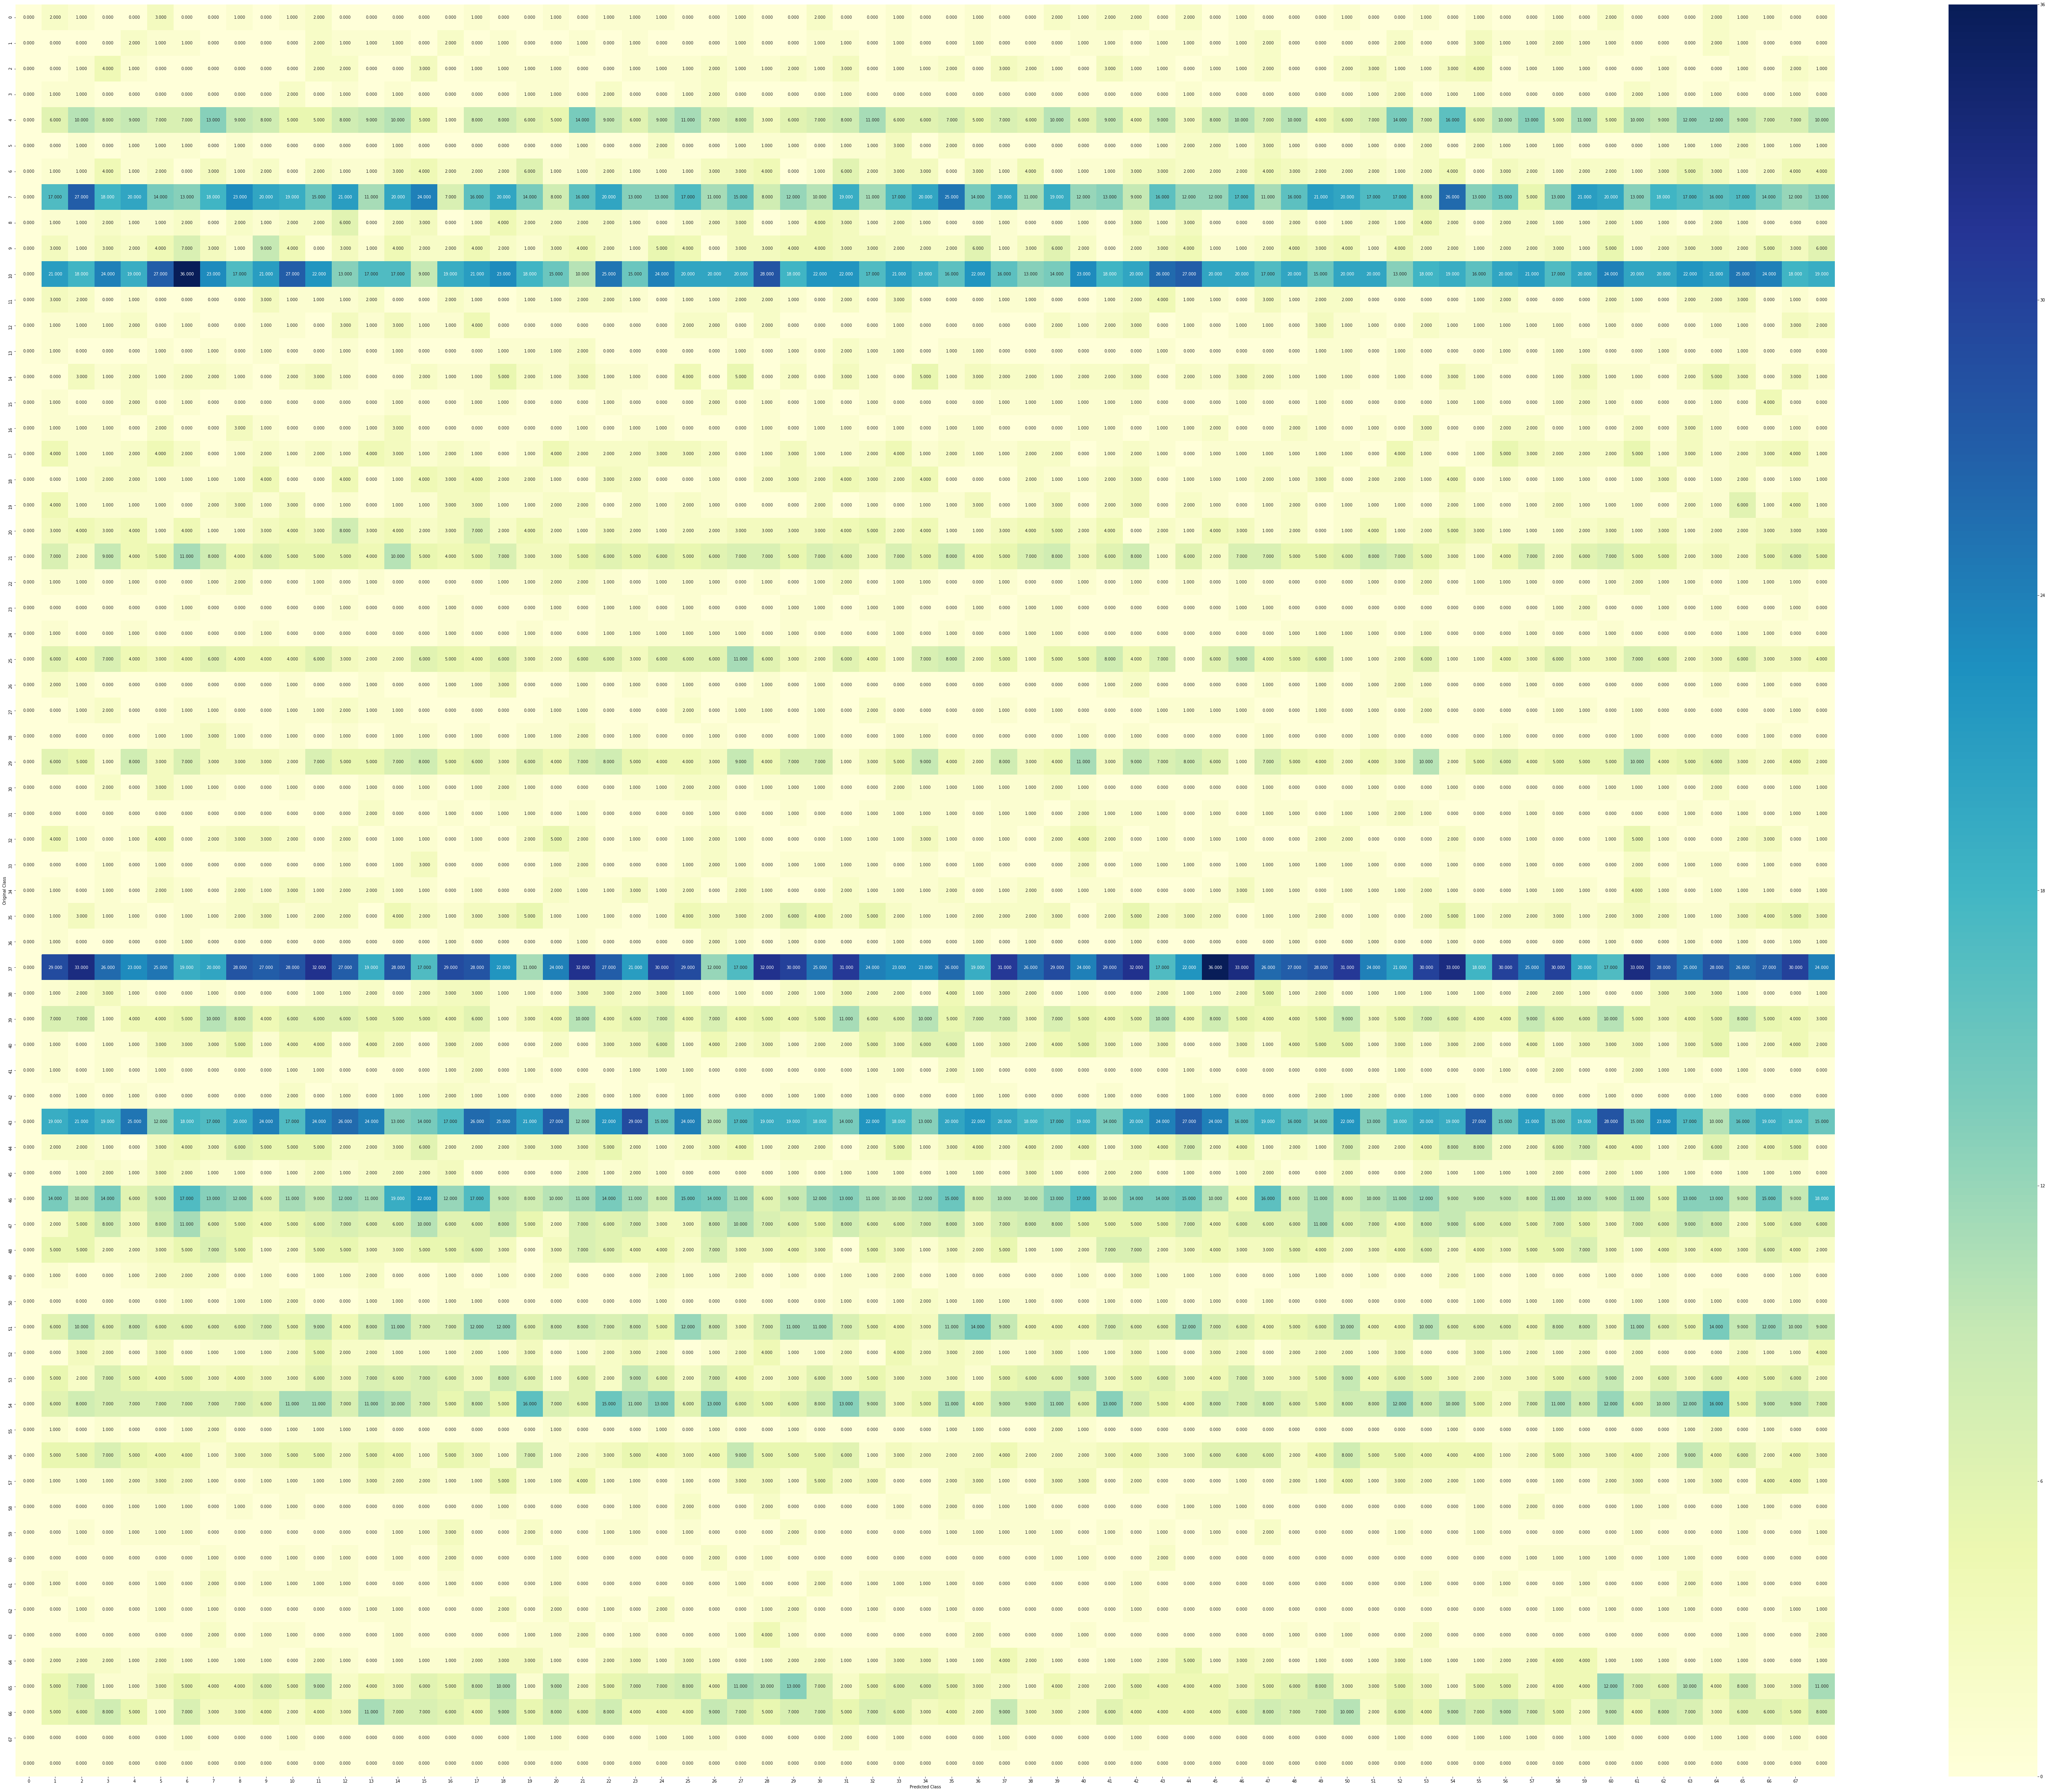

-------------------- Precision matrix (Columm Sum=1) --------------------


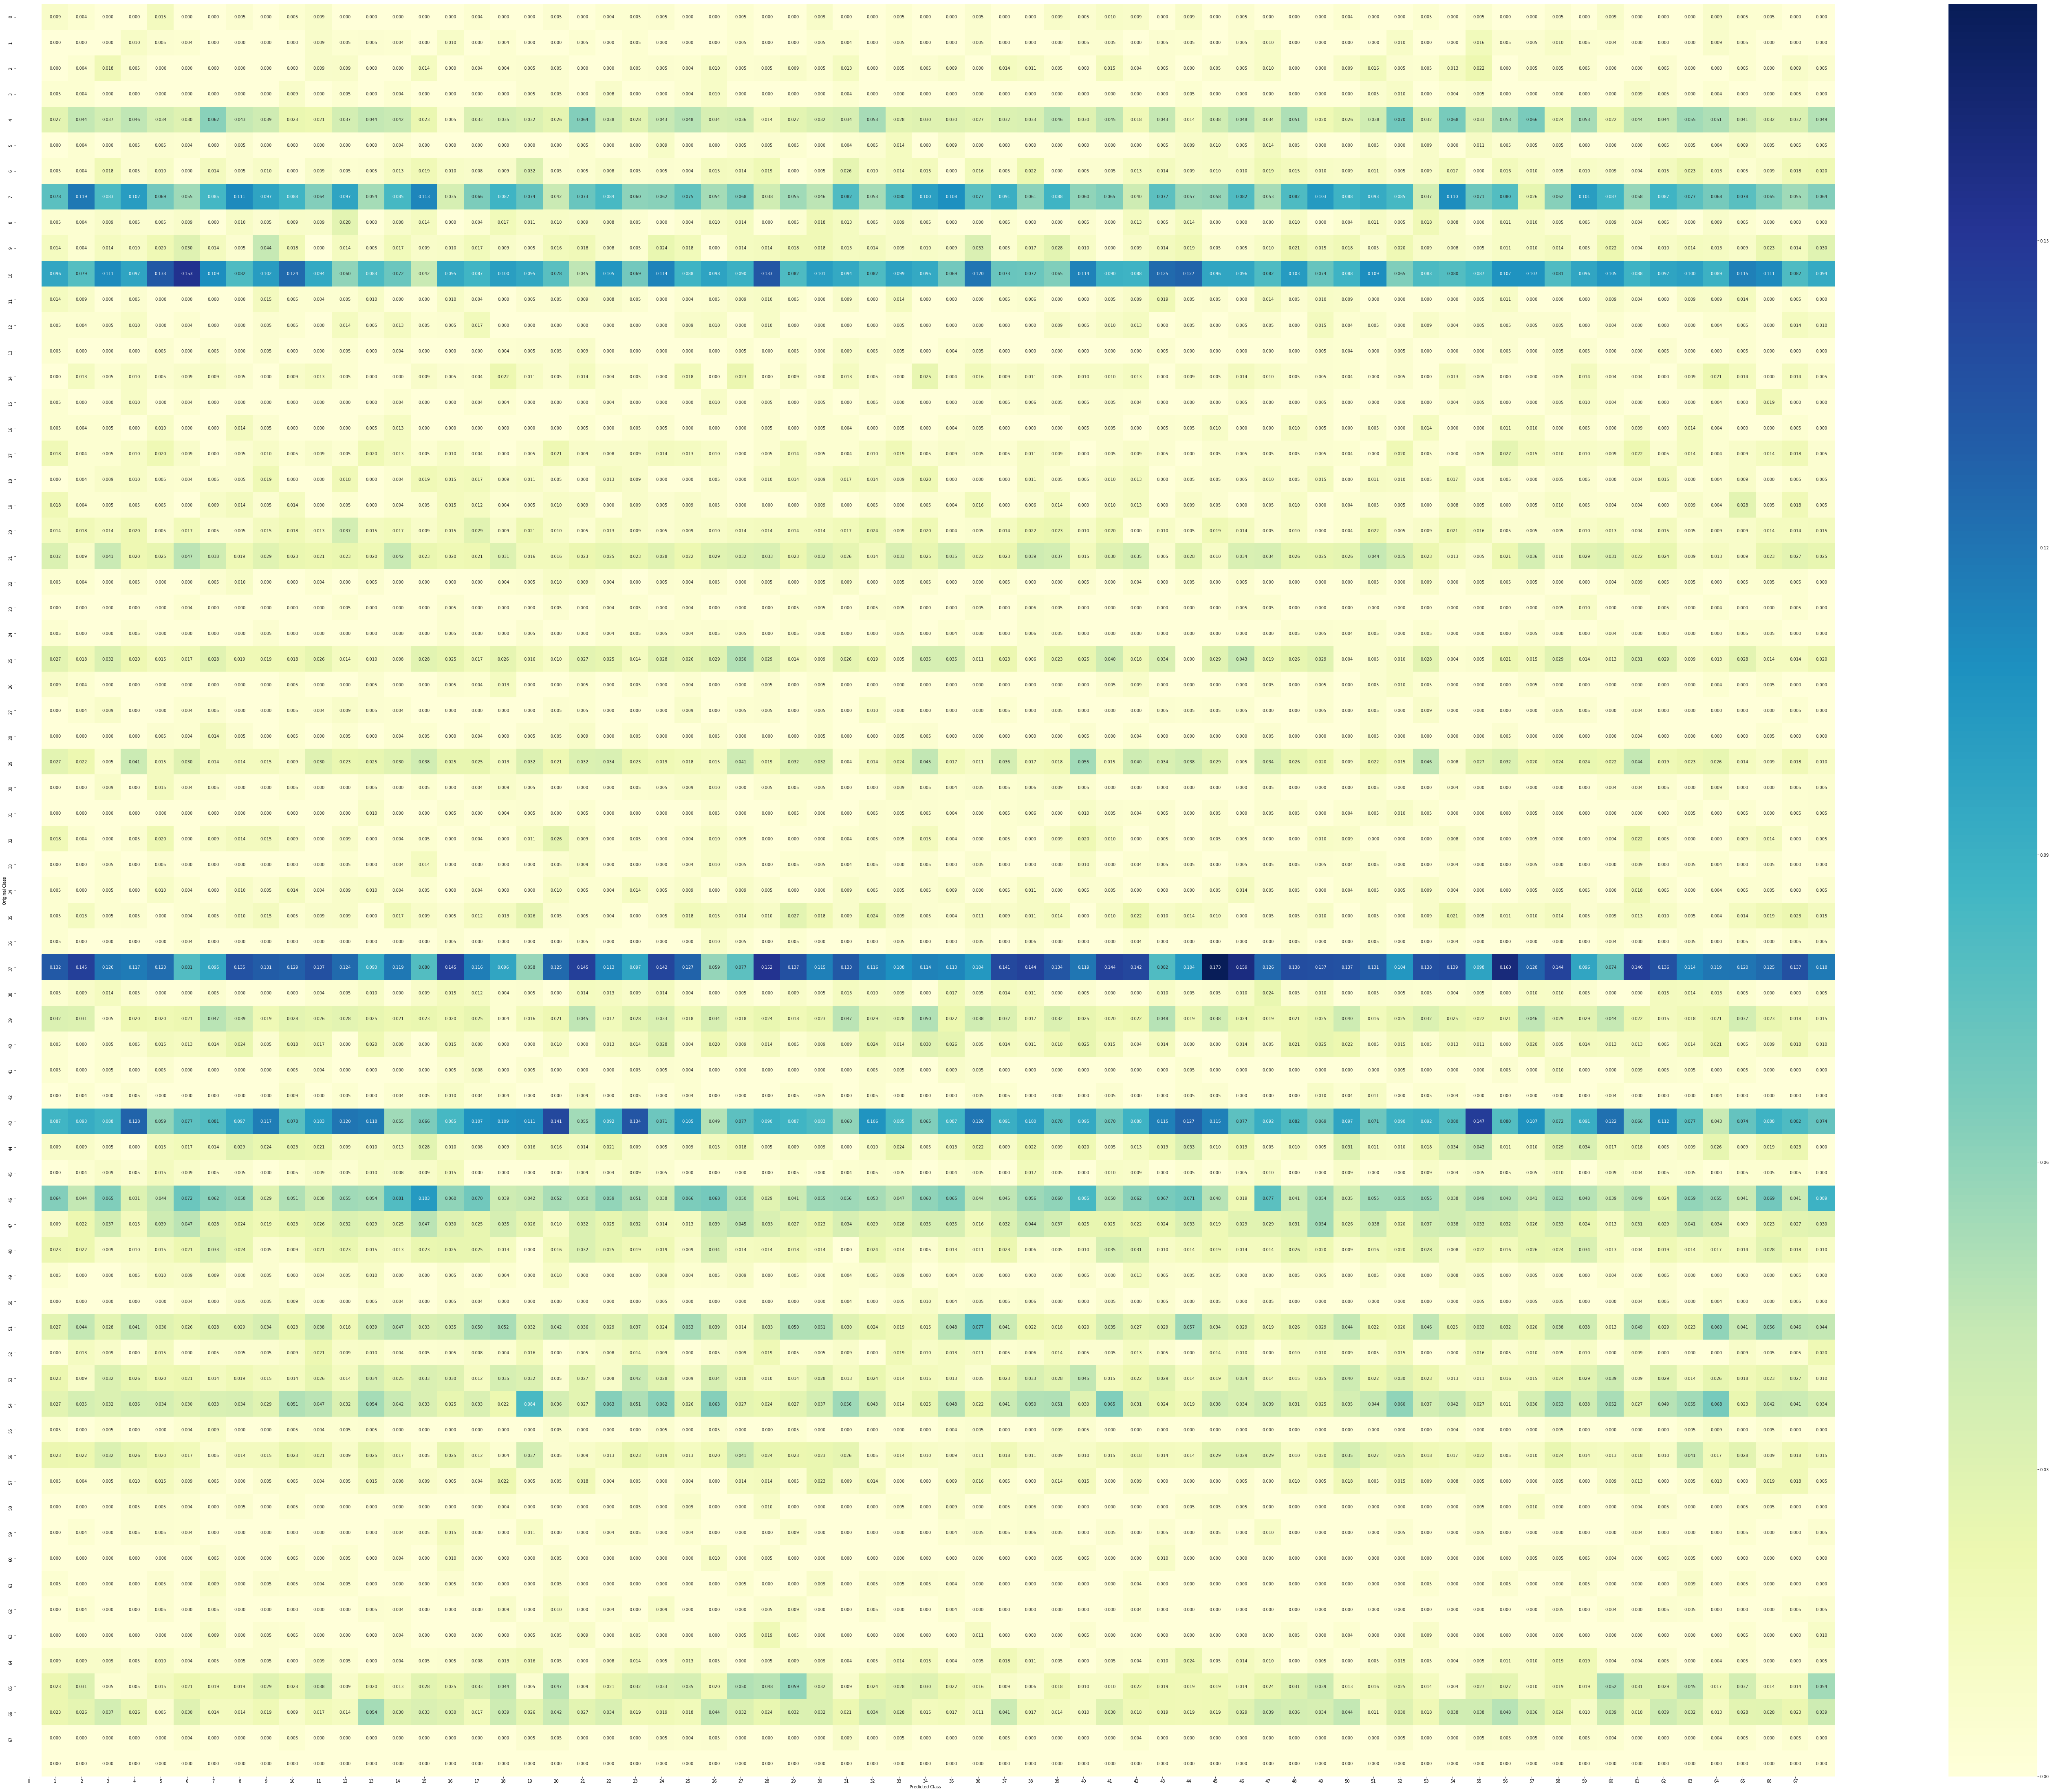

-------------------- Recall matrix (Row sum=1) --------------------


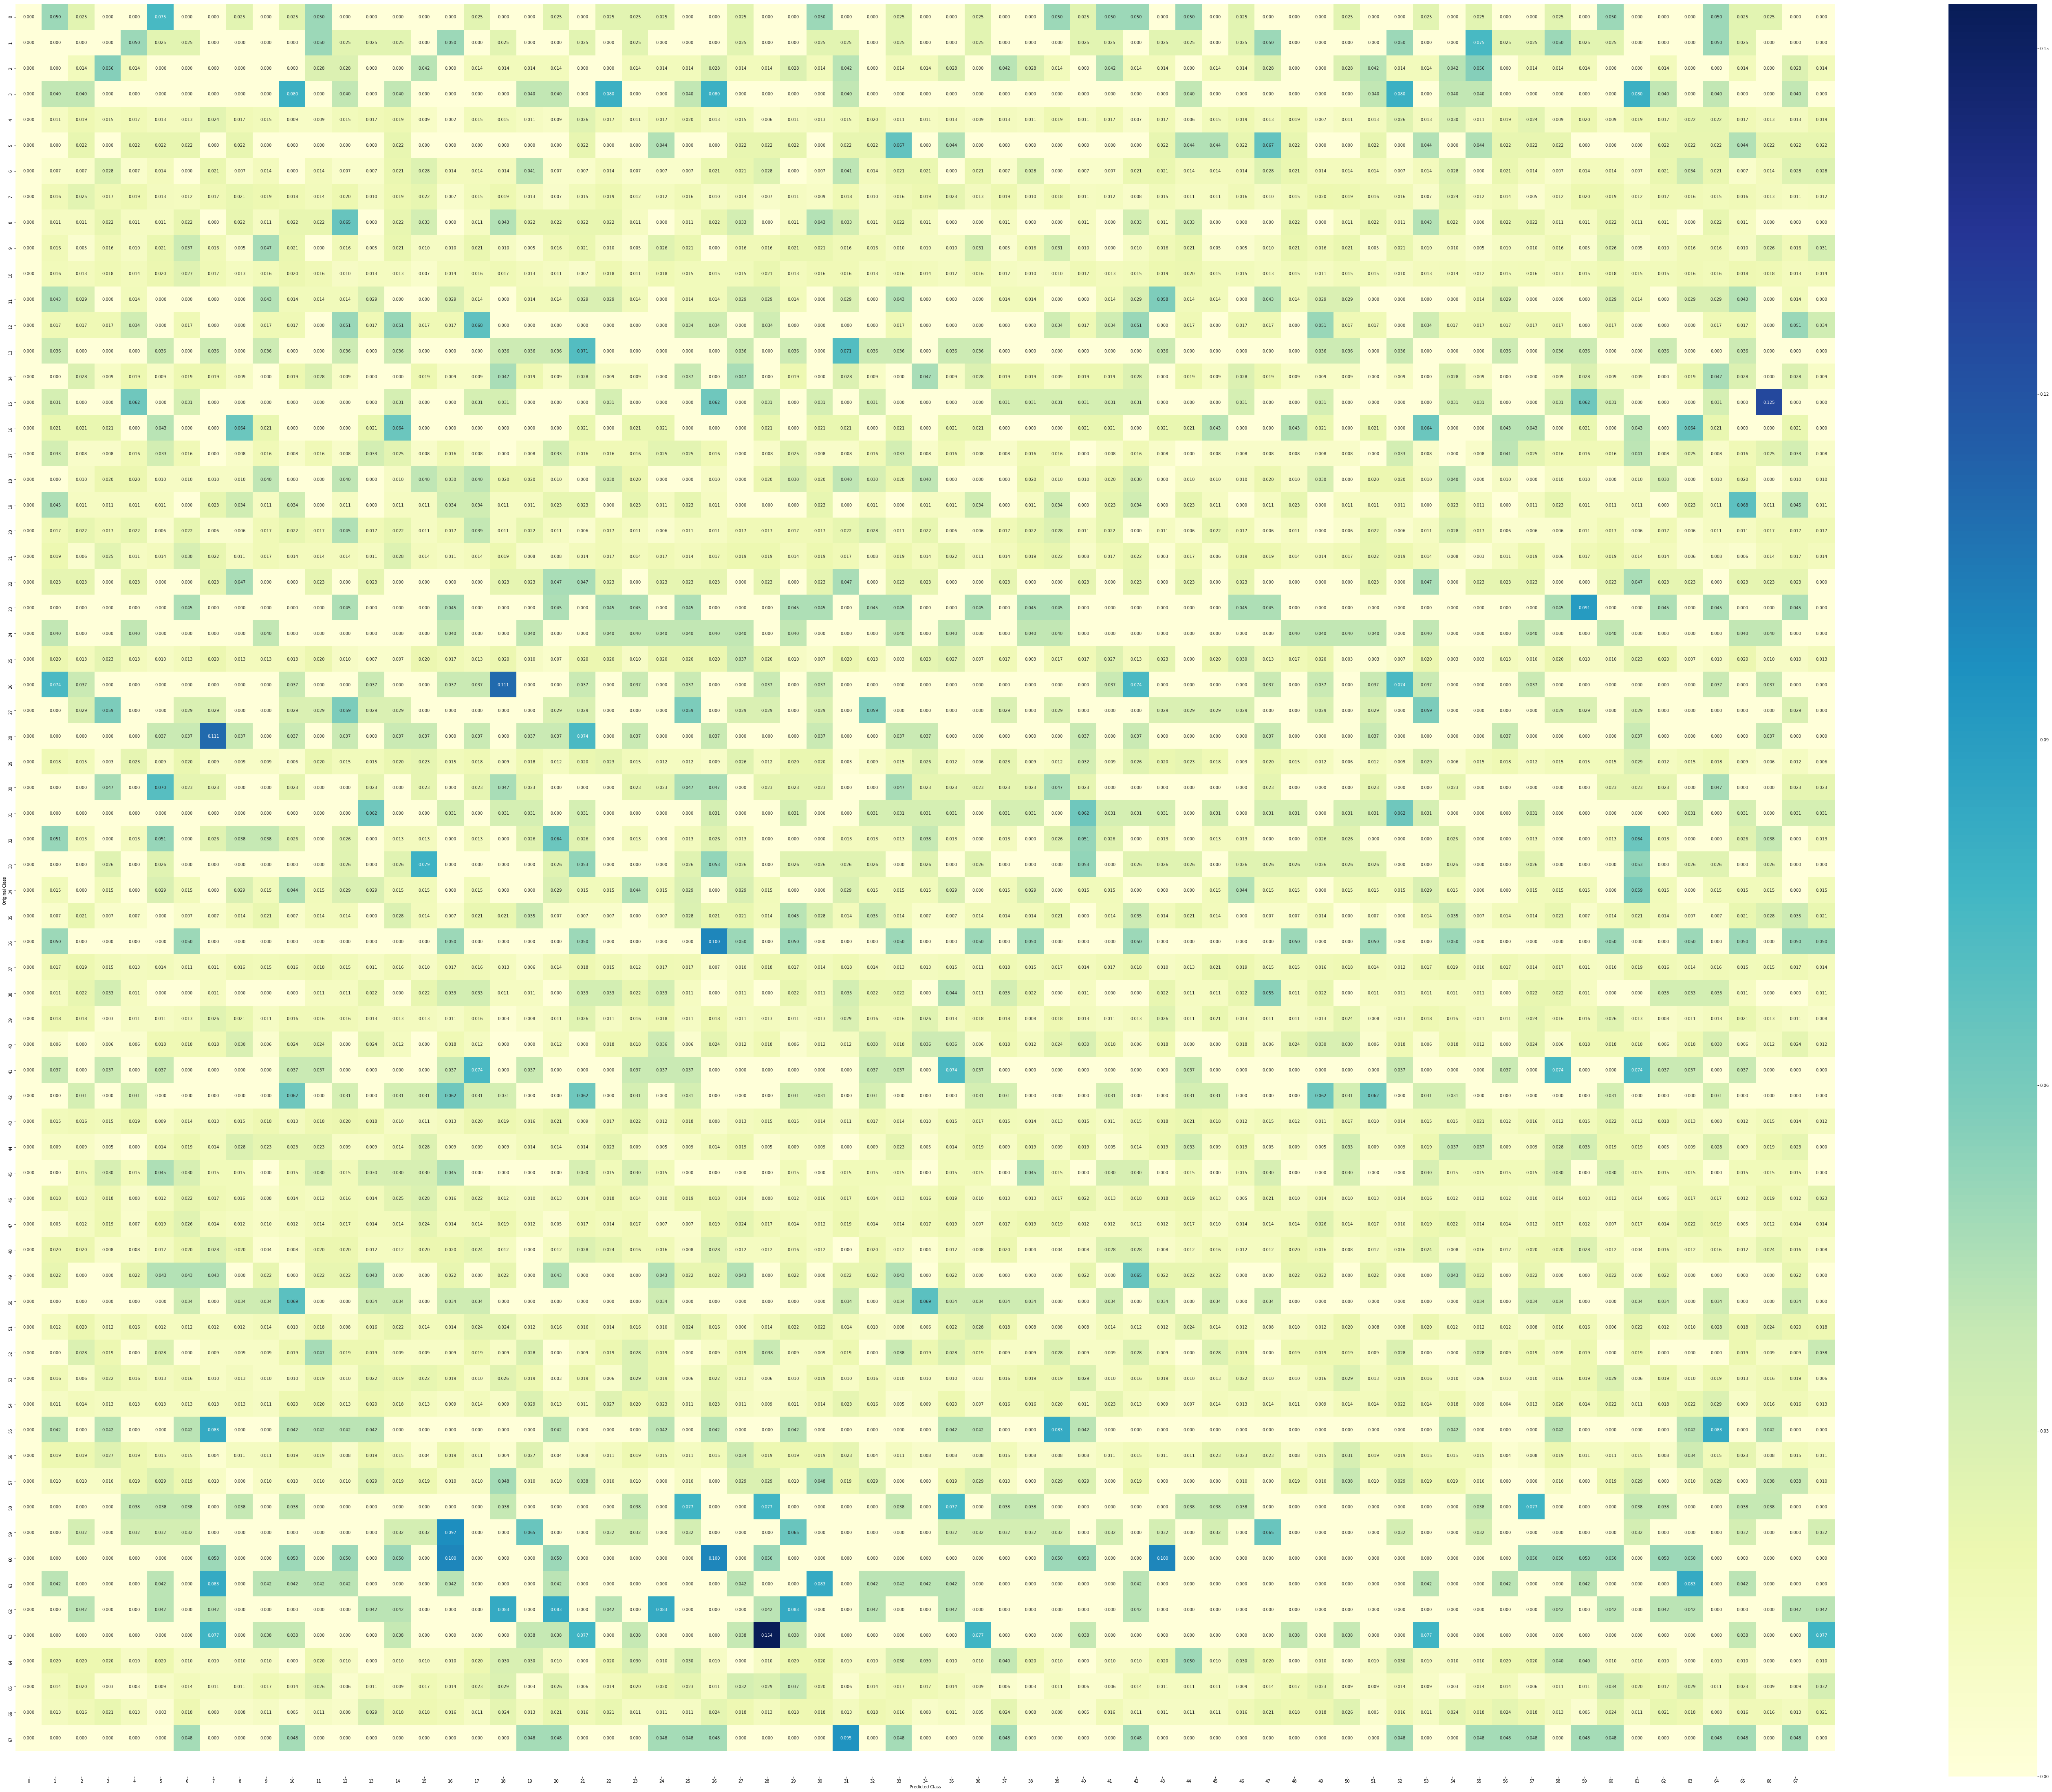

In [102]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,68))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,68)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,68))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,68)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [105]:
desc_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = desc_vectorizer.fit_transform(train_df['description'])
test_variation_feature_onehotCoding = desc_vectorizer.transform(test_df['description'])
cv_variation_feature_onehotCoding = desc_vectorizer.transform(cv_df['description'])

In [83]:
train_variation_feature_onehotCoding.shape

(46256, 22055)

For values of alpha =  1e-05 The log loss is: 1.56100978212
For values of alpha =  0.0001 The log loss is: 1.45623736683
For values of alpha =  0.001 The log loss is: 1.65323426265
For values of alpha =  0.01 The log loss is: 2.34522554973
For values of alpha =  0.1 The log loss is: 3.19103259262
For values of alpha =  1 The log loss is: 3.41065537787


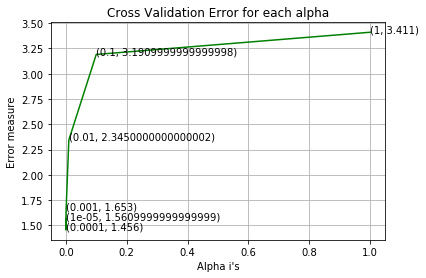

For values of best alpha =  0.0001 The train log loss is: 0.927412976115
For values of best alpha =  0.0001 The cross validation log loss is: 1.45623736683
For values of best alpha =  0.0001 The test log loss is: 1.44719264938


In [87]:

alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [104]:
title_vectorizer = CountVectorizer()
train_title_feature_onehotCoding = title_vectorizer.fit_transform(train_df['title'])
test_title_feature_onehotCoding = title_vectorizer.transform(test_df['title'])
cv_title_feature_onehotCoding = title_vectorizer.transform(cv_df['title'])

For values of alpha =  1e-05 The log loss is: 0.186714536813
For values of alpha =  0.0001 The log loss is: 0.20709773848
For values of alpha =  0.001 The log loss is: 0.344847211244
For values of alpha =  0.01 The log loss is: 0.91602593828
For values of alpha =  0.1 The log loss is: 2.05498348132
For values of alpha =  1 The log loss is: 2.62773684968


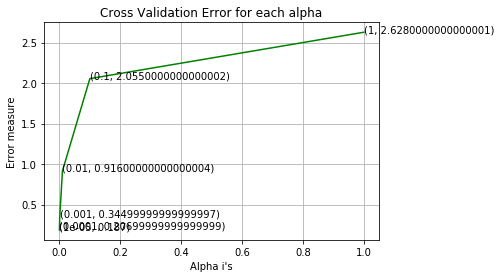

For values of best alpha =  1e-05 The train log loss is: 0.0986177711823
For values of best alpha =  1e-05 The cross validation log loss is: 0.186714536813
For values of best alpha =  1e-05 The test log loss is: 0.180694786314


In [107]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_title_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_title_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_title_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_title_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_title_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_title_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_title_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_title_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [108]:
train_x_onehotCoding = hstack((train_variation_feature_onehotCoding, train_title_feature_onehotCoding)).tocsr()
train_y = np.array(list(y_train['variety']))

test_x_onehotCoding = hstack((test_variation_feature_onehotCoding, test_title_feature_onehotCoding)).tocsr()
test_y = np.array(list(y_test['variety']))

cv_x_onehotCoding = hstack((cv_variation_feature_onehotCoding, cv_title_feature_onehotCoding)).tocsr()
cv_y = np.array(list(y_cv['variety']))


for alpha = 1e-05
Log Loss : 1.1327890149
for alpha = 0.0001
Log Loss : 1.03851187008
for alpha = 0.001
Log Loss : 0.945822362591
for alpha = 0.1
Log Loss : 1.00526406776
for alpha = 1
Log Loss : 1.92686496247
for alpha = 10
Log Loss : 2.77110767511
for alpha = 100
Log Loss : 2.97985795306
for alpha = 1000
Log Loss : 3.00468346797


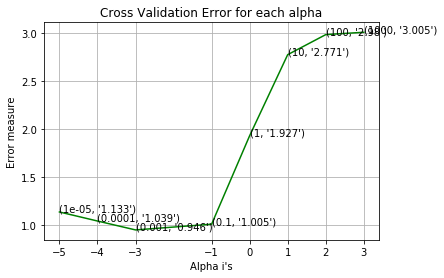

For values of best alpha =  0.001 The train log loss is: 0.35928034502
For values of best alpha =  0.001 The cross validation log loss is: 0.945822362591
For values of best alpha =  0.001 The test log loss is: 0.922239639953


In [110]:
from sklearn.naive_bayes import MultinomialNB
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 0.211634348364
For values of alpha =  0.0001 The log loss is: 0.193141333035
For values of alpha =  0.001 The log loss is: 0.332484858548
For values of alpha =  0.01 The log loss is: 1.09134429022
For values of alpha =  0.1 The log loss is: 2.57657009348
For values of alpha =  1 The log loss is: 3.36513757048


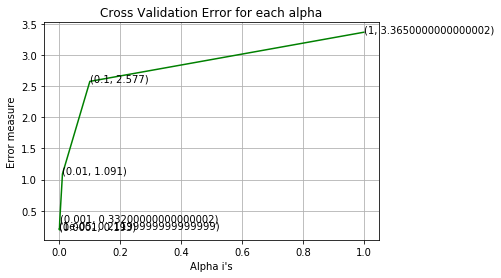

For values of best alpha =  0.0001 The train log loss is: 0.104441374587
For values of best alpha =  0.0001 The cross validation log loss is: 0.193141333035
For values of best alpha =  0.0001 The test log loss is: 0.193890390423


In [111]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
